# PyTorch Image Classifier

In [1]:
#Import PyTorch if using Google Colab
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x57afe000 @  0x7f4f273f32a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [2]:
#Check PIL version if using Colab. If below 5.3, restart runtime and run again.
import PIL
print(PIL.PILLOW_VERSION)

5.3.0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Import resources
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import json
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL

from PIL import Image
from collections import OrderedDict

import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

#from autoaugment import ImageNetPolicy

In [6]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('Bummer!  Training on CPU ...')
else:
    print('You are good to go!  Training on GPU ...')

You are good to go!  Training on GPU ...


In [0]:
data_dir = 'gdrive/My Drive/flower_data.zip (Unzipped Files)/flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [74]:
'''
from autoaugment import ImageNetPolicy
image = PIL.Image.open(path)
policy = ImageNetPolicy()
transformed = policy(image)
'''

'\nfrom autoaugment import ImageNetPolicy\nimage = PIL.Image.open(path)\npolicy = ImageNetPolicy()\ntransformed = policy(image)\n'

In [0]:
# Define the transforms for the training, validation, and testing sets

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)

In [0]:
# Label mapping
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)


In [10]:
#Download Densenet for the transfer learning
model = models.densenet161(pretrained=True)
model


/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.torch/models/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:02<00:00, 40860558.58it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [0]:
# Build and train your network
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2208, 500)),
                          ('relu', nn.ReLU()),
                          #('fc2', nn.Linear(4096, 1000)),
                          #('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier



# Testing the Network

In [0]:
# Train a model with a pre-trained network
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
sched = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [13]:
images  = next(iter(trainloader))
print(images[0].size())

torch.Size([64, 3, 224, 224])


In [14]:
# to switch to gpu if available
if torch.cuda.is_available():
    model.cuda()
else:
    model.cpu()
    
epochs = 20
steps = 0
print_every = 20
for e in range(epochs):
    running_loss = 0
    for images, labels in iter(trainloader):
        inputs, targets = images, labels
        steps += 1
        
        if torch.cuda.is_available():
            inputs, targets = inputs.cuda(), labels.cuda()
        
        optimizer.zero_grad()        
        output = model.forward(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if steps % print_every == 0:
            model.eval()
            accuracy = 0
            valid_loss = 0
            for ii, (images, labels) in enumerate(validloader):
                inputs, labels = images, labels
                with torch.no_grad():
                    if torch.cuda.is_available():
                        inputs, labels = inputs.cuda(), labels.cuda()

                    output = model.forward(inputs)
                    valid_loss += criterion(output, labels).item()
                    ps = torch.exp(output).data
                    equality = (labels.data == ps.max(1)[1])
                    accuracy += equality.type_as(torch.FloatTensor()).mean()
            print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/print_every),
              "Test Loss: {:.3f}.. ".format(valid_loss/len(validloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(validloader)))
            
            running_loss = 0
            model.train()

Epoch: 1/20..  Training Loss: 4.355..  Test Loss: 3.958..  Test Accuracy: 0.193
Epoch: 1/20..  Training Loss: 3.571..  Test Loss: 3.004..  Test Accuracy: 0.376
Epoch: 1/20..  Training Loss: 2.795..  Test Loss: 2.199..  Test Accuracy: 0.553
Epoch: 1/20..  Training Loss: 2.208..  Test Loss: 1.694..  Test Accuracy: 0.667
Epoch: 1/20..  Training Loss: 1.709..  Test Loss: 1.249..  Test Accuracy: 0.747
Epoch: 2/20..  Training Loss: 1.083..  Test Loss: 0.940..  Test Accuracy: 0.819
Epoch: 2/20..  Training Loss: 1.102..  Test Loss: 0.772..  Test Accuracy: 0.843
Epoch: 2/20..  Training Loss: 0.987..  Test Loss: 0.670..  Test Accuracy: 0.864
Epoch: 2/20..  Training Loss: 0.855..  Test Loss: 0.606..  Test Accuracy: 0.872
Epoch: 2/20..  Training Loss: 0.828..  Test Loss: 0.556..  Test Accuracy: 0.867
Epoch: 3/20..  Training Loss: 0.495..  Test Loss: 0.558..  Test Accuracy: 0.860
Epoch: 3/20..  Training Loss: 0.679..  Test Loss: 0.468..  Test Accuracy: 0.896
Epoch: 3/20..  Training Loss: 0.618..  T

In [15]:
# Testing the performance of the model
model.eval()
accuracy = 0
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
else:
    model.cpu()

for ii, (images, labels) in enumerate(validloader):
    inputs = images
    labels = labels
    with torch.no_grad():
        if cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        output = model.forward(inputs)
        ps = torch.exp(output).data
        equality = (labels.data == ps.max(1)[1])
        accuracy += equality.type_as(torch.FloatTensor()).mean()

print("Test Accuracy: {:.3f}".format(accuracy/len(validloader)))

Test Accuracy: 0.958


### Saving the Checkpoint

In [0]:
model.class_to_idx = trainloader.dataset.class_to_idx

In [17]:
# Save the checkpoint 
checkpoint = {'input_size': 2208,
              'output_size': 102,
              'epochs': epochs,
              'loss': loss,
              'batch_size': 64,
              'model': models.densenet161(pretrained=True),
              'classifier': classifier,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx
             }

torch.save(checkpoint, 'checkpoint.pth')

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


### Loading the checkpoint

In [18]:
ckpt = torch.load('checkpoint.pth')
ckpt.keys()

dict_keys(['input_size', 'output_size', 'epochs', 'loss', 'batch_size', 'model', 'classifier', 'optimizer', 'state_dict', 'class_to_idx'])

In [0]:
# Load the checkpoint and rebuild the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer = checkpoint['optimizer']
    epochs = checkpoint['epochs']
    
    for param in model.parameters():
        param.requires_grad = False
        
    return model, checkpoint['class_to_idx']

In [20]:
model, class_to_idx = load_checkpoint('checkpoint.pth')
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [0]:
idx_to_class = { v : k for k,v in class_to_idx.items()}

## Inference for Classification
### Image Preprocessing

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    # tensor.numpy().transpose(1, 2, 0)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image)
    return image

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

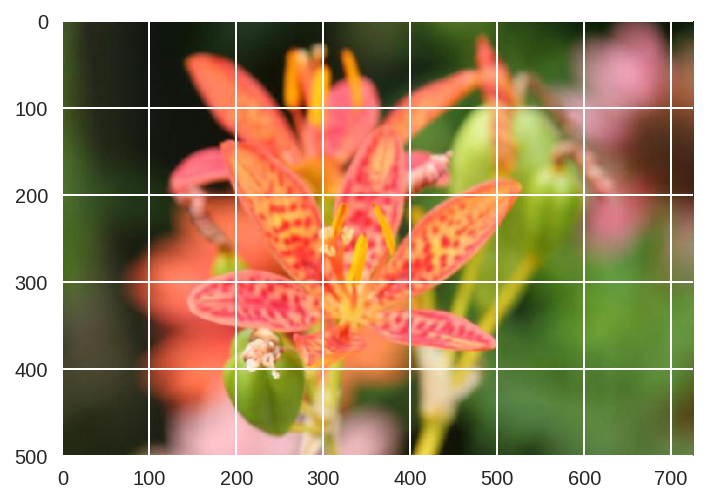

In [24]:
with Image.open('gdrive/My Drive/flower_data.zip (Unzipped Files)/flower_data/valid/102/image_08006.jpg') as image:
    plt.imshow(image)

### Class prediction

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    cuda = torch.cuda.is_available()
    if cuda:
        model.cuda()
    else:
        model.cpu()
        
    # TODO: Implement the code to predict the class from an image file
    image = None
    model.eval()
    with Image.open(image_path) as img:
        image = process_image(img)
    with torch.no_grad():
        if cuda:
            image = image.cuda()
    
        image = image.unsqueeze(0)
        output = model.forward(image.float())
        ps = torch.exp(output).data.cpu().numpy()[0]
        topk_index = np.argsort(ps)[-topk:][::-1] 
        idx = [idx_to_class[x] for x in topk_index]
        prob = ps[topk_index]
    return prob, idx

In [26]:
img_path = 'gdrive/My Drive/flower_data.zip (Unzipped Files)/flower_data/valid/18/image_04252.jpg'
probs, classes = predict(img_path, model)
print(probs)
print(classes)
print(([cat_to_name[x] for x in classes]))

[9.9969482e-01 1.2146245e-04 5.1700514e-05 3.1645814e-05 3.0671970e-05]
['18', '31', '91', '43', '83']
['peruvian lily', 'carnation', 'hippeastrum', 'sword lily', 'hibiscus']


### Sanity check

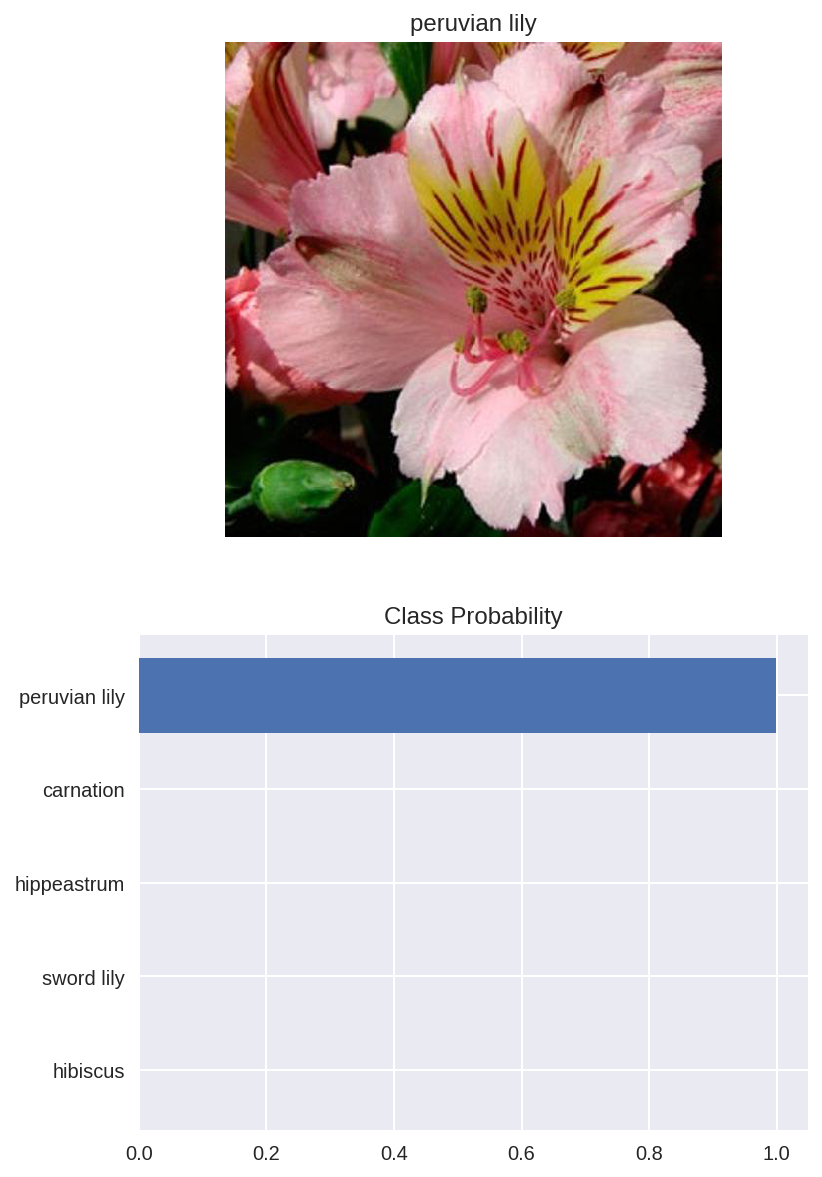

In [27]:
# TODO: Display an image along with the top 5 classes
def view_classify(img_path, prob, classes, mapping):
    ''' Function for viewing an image and it's predicted classes.
    '''
    image = Image.open(img_path)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    flower_name = mapping[img_path.split('/')[-2]]
    ax1.set_title(flower_name)
    ax1.imshow(image)
    ax1.axis('off')
    
    y_pos = np.arange(len(prob))
    ax2.barh(y_pos, prob, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapping[x] for x in classes])
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_title('Class Probability')

view_classify(img_path, probs, classes, cat_to_name)